In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import random
import time as tm
from scipy.optimize import curve_fit
import xml.dom.minidom as minidom

Welcome to JupyROOT 6.24/02


In [2]:
filename = "/Users/williamquinn/Desktop/A1400_B1400_t1119.xml"
file = minidom.parse(filename)

In [3]:
traces = file.getElementsByTagName('trace')
print(traces.length)

400000


In [4]:
trace = traces[0]
channel = int(trace.attributes['channel'].value)
print(channel)

0


In [5]:
def get_pulse_par(x, y, baseline):
    x = np.array(x)
    
    pulse_length = len(x)
    amplitude = np.min(y) - baseline;
    position = np.argmin(y)

    start=0
    stop=0
    for i in range(position):
    
        if (y[i]-baseline) < (0.3*amplitude):
            start = i
        if (y[i]-baseline) < (0.7*amplitude):
            stop = i
    
    rise = stop - start
    onset = start

    for i in range(position, pulse_length):
        if (y[i]-baseline) > (amplitude/np.exp(1.0)):
            stop = i;
    fall = stop - position
  
    return onset, rise, fall

def get_baseline(y):
    baseline = 0
    for i in range(100):
        baseline += y[i]
    return baseline/100

def get_amplitude(y, baseline):
    return np.min(y) - baseline

def pulse(x, onset, rise, fall, pos):
    y = []
    for i in range(len(x)):
        if i < onset:
            y.append(0)
        else:
            temp = -np.exp(-(x[i]-pos)/rise) + np.exp(-(x[i]-pos)/fall)
            y.append(temp)
    return y

Text(0.5, 0, 'timestamp /ns')

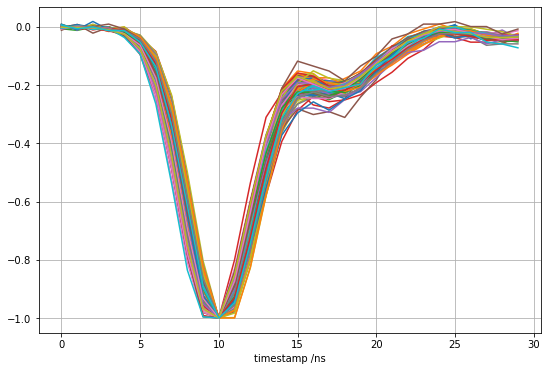

In [6]:
average_waveform = []
average_counter = 0
fig = plt.figure(figsize=(9,6), facecolor='white')
for i in range(int(traces.length)):
    trace = traces[i].firstChild.data.split(" ")[:-1]
    channel = int(traces[i].attributes['channel'].value)
    if channel == 1:
        continue
    waveform = np.array(trace, dtype='float')
    
    baseline = get_baseline(waveform)
    amplitude = get_amplitude(waveform, baseline)
    
    if amplitude > -100:
        continue
    
    if 0 in waveform:
        continue
    else:
        if len(average_waveform) == 0:
            average_waveform = np.zeros_like(waveform[:30])
        else:
            pos = np.argmin(waveform - baseline)
            size = np.min(waveform - baseline)
            if pos > 700:
                continue
            plt.plot(-1*(waveform - baseline)[pos-10:pos+20]/size)
            
            average_counter += 1
            average_waveform += -1*(waveform - baseline)[pos-10:pos+20]/size
            
            if average_counter == 100:
                break
            
    if i % 1000 == 0:
        print(i)
        
plt.grid()
plt.xlabel('timestamp /ns')

In [7]:
def gaus(x, A, mu, sig):
    return A*np.exp( -0.5*((x-mu)/sig)**2 )

[-1.00798842 10.11116109  2.21924508]


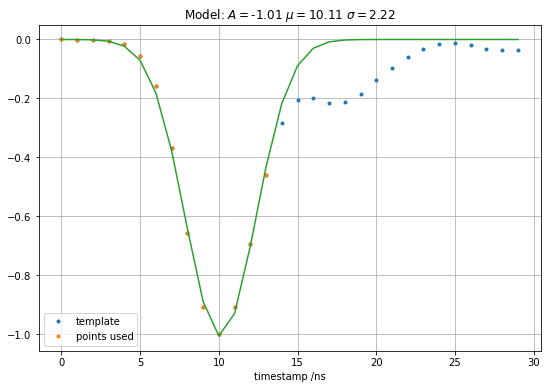

In [8]:
template = average_waveform/average_counter
fig = plt.figure(figsize=(9,6), facecolor='white')
plt.plot(template, ".", label='template')
x = np.array([i for i in range(len(template))])
popt, pcov = curve_fit(f=gaus, xdata=x[:-16], ydata=template[:-16], bounds = [[-1000, 0, 0], [0, 1000, 1000]])
plt.plot(x[:-16], template[:-16], ".", label ='points used' )
A = popt[0]
mu = popt[1]
sig = popt[2]
plt.plot(x,gaus(x,*popt))
print(popt)
plt.xlabel('timestamp /ns')
plt.grid()
plt.title(r'Model: $A=${:.2f} $\mu=${:.2f} $\sigma=${:.2f}'.format(popt[0], popt[1], sig))
plt.legend()
#plt.yscale('log')
plt.savefig('/Users/williamquinn/Desktop/pulse_fit.pdf')

In [9]:
def gaus_fix_sig(x, A, mu):
    return A*np.exp( -0.5*((x-mu)/2.21924508)**2 )

In [10]:
counter = 0
fit_counter = 0
charges = []
for i in range(int(traces.length)):
    trace = traces[i].firstChild.data.split(" ")[:-1]
    channel = int(traces[i].attributes['channel'].value)
    if channel == 1:
        continue
    waveform = np.array(trace, dtype='float')
    
    baseline = get_baseline(waveform)
    amplitude = get_amplitude(waveform, baseline)
    
    if i % 10000 == 0:
        print(i)
    
    if amplitude > -50:
        continue
        
    if 0 in waveform:
        pass
    else:
        charge = np.sum((waveform - baseline)[pos-10:pos+20])/50
        charges.append(charge)
        continue
    
    # pos = np.argmin(waveform - baseline)
    pos = np.where( waveform==0 )[0]
    
    middle = int(len(pos) / 2) # = int(2.5) = 2
    pos=pos[middle] # 3
    size = np.min(waveform - baseline)
    
    waveform_r = (waveform - baseline)[pos-10:pos+20]
    pulse = waveform[pos-10:pos+20]
    
    #fig = plt.figure(figsize=(9,6), facecolor='white')
    #plt.plot([k for k in range(len(waveform_r))], waveform_r, '.', label='pmt pulse')
    # plt.plot([k for k in range(len(waveform_r))], template*-1*size *1.7, '.')
    #plt.grid()
    #plt.xlabel('timestamp /ns')
    #plt.ylabel('Voltage /mV')
    
    fit_counter += 1
    shapes = []
    # sizes = np.linspace(0,5,5000)
    sizes = [1]
    
    new_pulse = []
    xi = []
    for j in range(len(pulse)):
        if j > 14:
            break
        if pulse[j] == 0:
            continue
        else:
            new_pulse.append(waveform_r[j])
            xi.append(j)
            
    popt, pcov = curve_fit(f=gaus_fix_sig, xdata=np.array(xi), ydata=new_pulse, bounds=[[-10000, 0], [0, 40]])
    
    #plt.plot([k for k in range(len(waveform_r))], -1*template*popt[0], '.', label='scaled template')
    #plt.plot([k for k in range(len(waveform_r)-15)], gaus_fix_sig([k for k in range(len(waveform_r)-15)], *popt), label='model')
    #plt.plot(xi, new_pulse, '.', label='model points')
    # print(xi, popt)
    #plt.legend()
    #plt.title(r'Model: $A=${:.2f} $\mu=${:.2f} $\sigma=${:.2f}'.format(popt[0], popt[1], sig))
    #plt.savefig("/Users/williamquinn/Desktop/fit_plot_{}.pdf".format(fit_counter))
    #plt.close()
    
    new_temp = -1*template*popt[0]
    charge = np.sum(new_temp)/50
    
    charges.append(charge)
    
    '''sizes = np.linspace(0,5000,5000)
    for i_size in sizes:
        test = []
        temp = []
        for j in range(len(waveform_r)):
            if pulse[j] == 0:
                continue
            else:
                temp.append(template[j])
                test.append(waveform_r[j])
                
            if j > 14:
                break
        test=np.array(test)
        temp=np.array(temp)
        shapes.append(np.sum((temp*-1*i_size - test)/(temp*-1*i_size)))
        #shape = np.dot(test, temp*-1*i_size)
        #shapes.append(shape)
    #amp = sizes[np.argmin(shapes)]
    #print(amp)'''
    
    '''if fit_counter == 10:
        break'''
    

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000


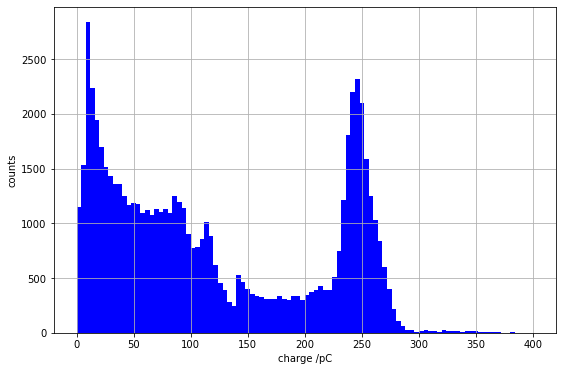

In [11]:
fig = plt.figure(figsize=(9,6), facecolor='white')
freq, bin_edges = np.histogram(-1*np.array(charges), 100, range=(0,400))
width = bin_edges[-1] - bin_edges[-2]
bin_centres = bin_edges[:-1] + width/2
plt.bar(bin_centres, freq, width=width, color="blue")
plt.xlabel('charge /pC')
plt.ylabel('counts')
plt.grid()
plt.savefig("/Users/williamquinn/Desktop/1400V_bi207_charge_spec.pdf")

In [86]:
file = ROOT.TFile("/Users/williamquinn/Desktop/pmt_short_templates.root", "READ")
file.ls()

TFile**		/Users/williamquinn/Desktop/pmt_short_templates.root	
 TFile*		/Users/williamquinn/Desktop/pmt_short_templates.root	
  KEY: TH1D	Template_Ch0;1	Template_Ch0
  KEY: TH1D	Template_Ch1;1	Template_Ch1


1 -217.99499999999978
2 -589.9949999999998
3 -1531.9949999999994
4 -4323.994999999999
5 -10492.994999999999
6 -20545.994999999977
7 -30571.995
8 -35233.99500000005
9 -32111.995000000035
10 -23645.994999999988
11 -14178.994999999995
12 -7388.995000000001
13 -4541.995000000001
14 -4761.994999999999
15 -5972.995000000003
16 -6514.994999999999
17 -5681.995000000001
18 -4103.994999999999
19 -2570.994999999999
20 -1473.9949999999994


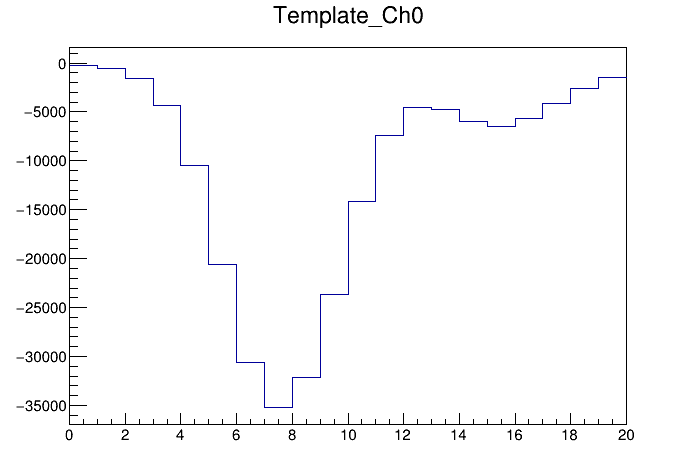

In [96]:
ROOT.gStyle.SetOptStat(0)
short_template = file.Get("Template_Ch0")
short_temp = []
for i in range(1, short_template.GetNbinsX() + 1):
    print(i, short_template.GetBinContent(i))
    short_temp.append(short_template.GetBinContent(i))
can = ROOT.TCanvas()
can.cd()
short_template.Draw()
can.Draw()
short_temp = np.array(short_temp)

20
-0.51095673137043


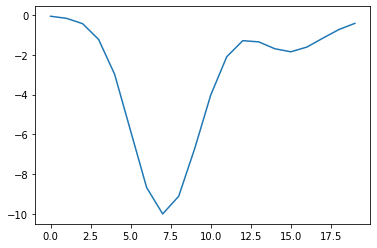

In [103]:
print(len(short_temp))
norm_short_temp = short_temp/np.sqrt(np.dot(short_temp, short_temp))
amp = np.min(norm_short_temp)
print(amp)
plt.plot(10*norm_short_temp /amp * -1)

In [108]:
35.22803183690809*amp

-18.0

(900.0, 1000.0)

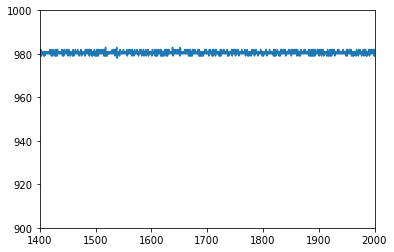

In [109]:
file = ROOT.TFile("/Users/williamquinn/Desktop/110011_A1400_B1400_t0127_3.root", "READ")
tree = file.T

for event in tree:
    waveform = event.waveform
    
    plt.plot(waveform)
plt.xlim(1400,2000)
plt.ylim(900,1000)

In [112]:
file = open("/Users/williamquinn/Desktop/ratios.csv", 'r')
fl = file.readlines()
x = []
y = []
for index, line in enumerate(fl):
    line_list = line.split(",")
    x.append(int(line_list[0].strip()))
    y.append(float(line_list[1].strip()))
x = np.array(x)
y = np.array(y)

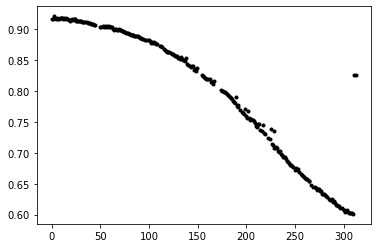

In [114]:
plt.plot(x,y, '.k')

In [12]:
import pandas as pd
def my_matrix():
    df = pd.read_csv("/Users/williamquinn/Desktop/HeMatrix.txt",
                     index_col=0)
    df = df / 500
    df.loc["i0", "0"] = 1
    M = df.values
    
    return M
print(my_matrix())

[[1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.168 0.832 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.084 0.334 0.582 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.028 0.106 0.4   0.466 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.006 0.07  0.238 0.4   0.286 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.034 0.152 0.286 0.35  0.178 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.006 0.024 0.06  0.236 0.358 0.228 0.086 0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.004 0.052 0.198 0.252 0.294 0.162 0.038 0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.01  0.046 0.116 0.228 0.252 0.228 0.098 0.022 0.    0.    0.
 

[0.0, 0.832, 1.498, 2.3040000000000003, 2.89, 3.4859999999999998, 3.947895791583167, 4.418, 4.852000000000001, 5.292000000000001, 5.734000000000001, 5.888, 6.226, 6.6080000000000005, 6.8740000000000006, 7.022, 7.1080000000000005, 7.314, 7.432865731462926]


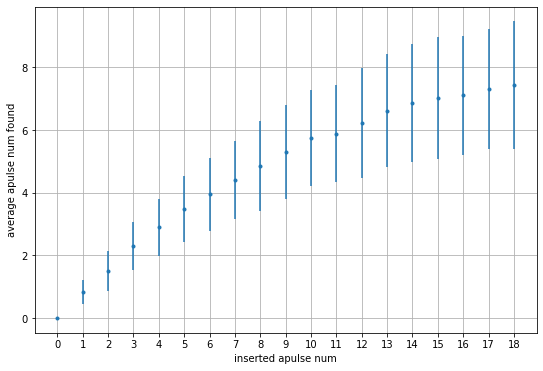

In [42]:
averages = []
stds = []
nums = np.array([i for i in range(len(M[0]))])
M = my_matrix()
plt.figure(figsize=(9,6), facecolor='white')
for i_row in range(len(M)):
    weights = []
    for i_col in range(len(M[i_row])):
        weights.append(M[i_row][i_col])
    weights = np.array(weights)
    average = np.average(nums, weights=weights)
    
    std = np.sqrt( np.sum(weights*(nums - average)**2)/np.sum(weights) )
    stds.append(std)
    averages.append(average)
print(averages)
plt.errorbar(nums, averages, yerr=stds, fmt=".")
plt.grid()
plt.xlabel("inserted apulse num")
plt.ylabel("average apulse num found")
_ =plt.xticks([i for i in range(len(M[0]))])

0.0
0.6541728786372303
1.1455901914863436
1.709761568585154
2.0971134288221442
2.4705767913484906
2.7460603463712947
3.014511025325337
3.252245224699875
3.483942338968166
3.7077614316214764
3.7837243764006367
3.9469004382439046
4.1255770531827185
4.246455676595833
4.312459603621989
4.3504016545384046
4.440050594393829
4.4909812483526474


Text(0.5, 0, 'num apulses')

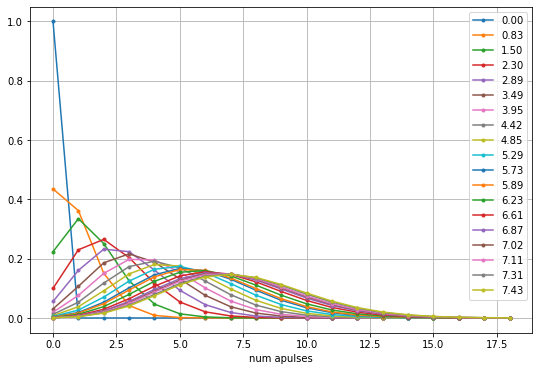

In [43]:
plt.figure(figsize=(9,6), facecolor='white')
for i_mean in averages:
    probs = []
    for n in nums:
        prob = np.exp(-1*i_mean)*(i_mean**n)/np.math.factorial(n)
        probs.append(prob)
    plt.plot(probs, ".-", label='{:.2f}'.format(i_mean))

    number = np.dot(averages, probs)
    print(number)
plt.grid()
plt.legend(loc='best')
plt.xlabel('num apulses')

0.0
0.15659902852161225
0.3088096362009346
0.45777081156363303
0.6041858315696889
0.7484631275098108
0.8908157124889522
1.0313309589740256
1.1700191831944253
1.306847098927717
1.4417604849115062
1.574699178802329
1.7056066295954733
1.8344356108899607
1.9611512478731143
2.085732189812908
2.2081705300227137
2.3284709100447047
2.4466491251694387
2.562730460902019
2.6767479251428923
2.7887404920971477
2.898751436732804
3.006826809888978
3.113014081799061
3.217360964429794
3.3199144096827493
3.4207197704902526
3.5198201046761253
3.6172555967661144
3.7130630704098997
3.807275563436394
3.8999219385436454
3.9910265049681892
4.080608629933642
4.168682322994446
4.255255781321109
4.340330889277381
4.423902671085377
4.505958700743042
4.586478478446308
4.665432787393871
4.742783048856741
4.818480696646484
4.892466594513326
4.964670521478438
5.035010750616203
5.103393746348229
5.169714003918781
5.2338540524492645
5.295684639902555
5.355065114535139
5.411844013104166
5.46585986136998
5.51694218744381

Text(0.5, 0, 'num apulses')

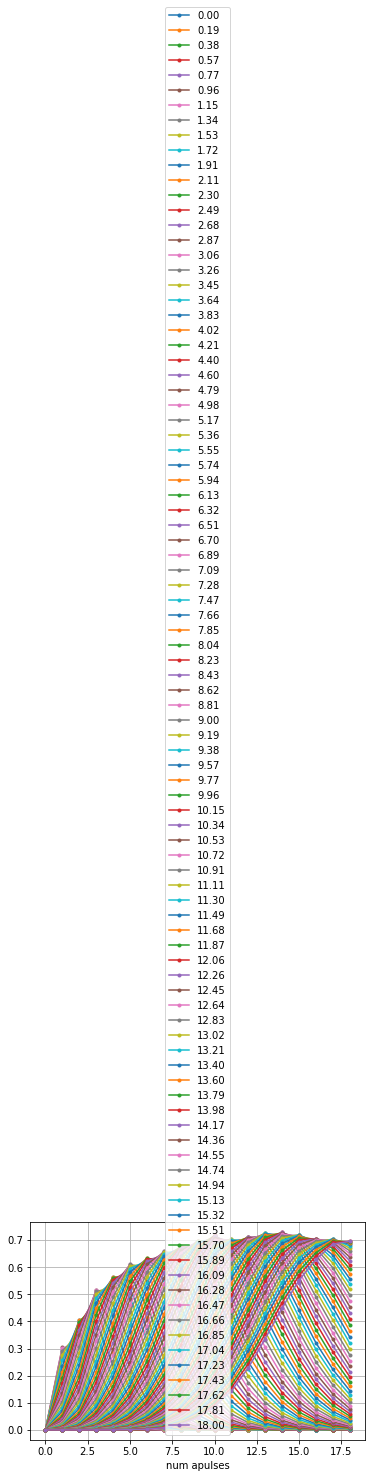

In [56]:
means = np.linspace(0, 18, 19*5)
f = []
for i_mean in means:
    probs = []
    for n in nums:
        prob = np.exp(-1*i_mean)*(i_mean**n)/np.math.factorial(n) * averages[n]
        probs.append(prob)
    print(np.sum(probs))
    f.append(np.sum(probs))
        
    plt.plot(probs, ".-", label='{:.2f}'.format(i_mean))

plt.grid()
plt.legend(loc='best')
plt.xlabel('num apulses')
        

Text(0.5, 0, 'observed average apulse num')

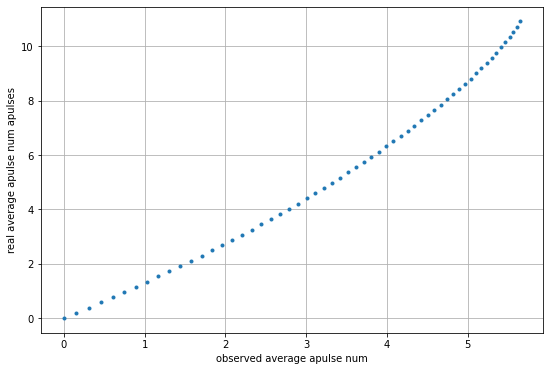

In [66]:
f = np.array(f)
my_list = np.where(means < 11)[0]
plt.figure(figsize=(9,6), facecolor='white')
plt.plot(f[my_list], means[my_list], ".")
plt.grid()
plt.ylabel('real average apulse num apulses')
plt.xlabel('observed average apulse num')